In [3]:
import pandas as pd
import numpy as np

# CL计算步骤

构建样本

In [4]:
p_0 = [0.9, 0.9, 0.5, 0.3, 0.3, 0.2, 0.2, 0.4, 0.5, 0.6,0.9, 0.9, 0.5, 0.3, 0.3, 0.2, 0.2, 0.4, 0.5, 0.6]
p_1 = [0.1, 0.1, 0.5, 0.7, 0.7, 0.9, 0.8, 0.7, 0.5, 0.4,0.1, 0.1, 0.5, 0.7, 0.7, 0.9, 0.8, 0.7, 0.5, 0.4]
label_origin = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1,0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
# 构建DataFrame
dict_data = {
    "j=0": p_0,
    "j=1": p_1,
    "label_origin": label_origin,
}
df_data = pd.DataFrame(dict_data)
df_data = df_data[:10]
df_data

,j=0,j=1,label_origin
0,0.9,0.1,0
1,0.9,0.1,0
2,0.5,0.5,0
3,0.3,0.7,0
4,0.3,0.7,0
5,0.2,0.9,1
6,0.2,0.8,1
7,0.4,0.7,1
8,0.5,0.5,1
9,0.6,0.4,1


1. 计算置信度阈值

In [5]:
list_0 = list()
list_1 = list()
for index, row in df_data.iterrows():
  if row['label_origin'] == 0:
    list_0.append(row['j=0'])
  elif row['label_origin'] == 1:
    list_1.append(row['j=1'])
  else:
    pass
thershold_p0 = np.mean(list_0)
thershold_p1 = np.mean(list_1)
print("the thersholds of p0 and p1 are {}, {}", thershold_p0, thershold_p1 )

the thersholds of p0 and p1 are {}, {} 0.5799999999999998 0.66


2. 获取计数矩阵 $C_{\overline{y}, y^*}$

In [6]:
manual_labels = ['manual_0','manual_1']
true_labels = ['true_0','true_1']
df_count = pd.DataFrame(data=0, index=manual_labels, columns= true_labels, dtype=float)

for index, row in df_data.iterrows():
    label = int(row["label_origin"])
    if row['j=0'] >= thershold_p0 and row['j=0']  > row['j=1']:
        if label == 0:
            df_count.loc['manual_0','true_0'] = df_count.loc['manual_0','true_0'] + 1
        elif label == 1:
            df_count.loc['manual_1','true_0'] = df_count.loc['manual_1','true_0'] + 1
        else:
            pass
    elif row['j=1'] >= thershold_p1 and row['j=1']  > row['j=0']:
        if label == 0:
            df_count.loc['manual_0','true_1'] = df_count.loc['manual_0','true_1'] + 1
        elif label == 1:
            df_count.loc['manual_1','true_1'] = df_count.loc['manual_1','true_1'] + 1
        else:
            pass
print(df_count)


          true_0  true_1
manual_0     2.0     2.0
manual_1     1.0     3.0


3. 校准数据，让每行之和等于对应标签数

In [7]:
manulal_label_0_num = (df_data['label_origin'] == 0).sum()
manulal_label_1_num = (df_data['label_origin'] == 1).sum()

df_count.loc['manual_0'] = df_count.loc['manual_0'] / df_count.loc['manual_0'].sum() * manulal_label_0_num
df_count.loc['manual_1'] = df_count.loc['manual_1'] / df_count.loc['manual_1'].sum() * manulal_label_1_num
df_count

,true_0,true_1
manual_0,2.50,2.50
manual_1,1.25,3.75


4. 计算联合分布

In [8]:
df_count = df_count / df_count.sum().sum()
df_count

,true_0,true_1
manual_0,0.250,0.250
manual_1,0.125,0.375


# 使用cleanlab2.0
[使用cleanlab2.0](https://docs.cleanlab.ai/v2.0.0/tutorials/image.html)

In [9]:
import numpy as np
import torch
import warnings

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

In [10]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),  # 将PIL Image或numpy.ndarray转换为tensor，并自动将像素值范围从[0, 255]变为[0.0, 1.0]
    transforms.Normalize((0.1307,), (0.3081,))  # 根据均值和标准差对张量图像进行标准化
])

# 下载训练集
train_dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=True)

# 下载测试集
test_dataset = datasets.MNIST(root='../data', train=False, transform=transform, download=True)

# 使用 DataLoader 来加载数据
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)



In [11]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")  # Fetch the MNIST dataset

X = mnist.data.astype("float32").to_numpy() # 2D array (images are flattened into 1D)
X /= 255.0  # Scale the features to the [0, 1] range
X = X.reshape(len(X), 1, 28, 28)  # reshape into [N, C, H, W] for PyTorch

y = mnist.target.astype("int64").to_numpy()  # 1D array of labels

In [12]:
from torch import nn

class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

In [13]:
from skorch import NeuralNetClassifier

model_skorch = NeuralNetClassifier(ClassifierModule)

In [14]:
from sklearn.model_selection import cross_val_predict

num_crossval_folds = 3  # for efficiency; values like 5 or 10 will generally work better
pred_probs = cross_val_predict(
    model_skorch,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba",
    n_jobs=4
)

/data2/fyang/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data2/fyang/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data2/fyang/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.7540       0.9153        0.3329  89.0838
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6877       0.9276        0.2758  89.9270
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.7560       0.9290        0.2877  99.9184
      2        0.2021       0.9504        0.1801  29.2458
      2        0.2288       0.9436        0.2109  42.6391
      2        0.1897       0.9502        0.1804  43.2276
      3        0.1411       0.9582        0.1422  11.3423
      3        0.1627       0.9534        0.1642  12.0812
      3        0.1370       0.9595        0.1440  11.9652
      4        0.1130       0.9624        0.1217  9.6235
      4        0.1116       0.9641        0.1235  9.9323
      4        0

In [21]:
import matplotlib.pyplot as plt

def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(X[id].reshape(28, 28), cmap="gray")
        plt.title(f"id: {id} \n label: {y[id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0)

In [16]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.9765428571428572


In [17]:
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    y,
    pred_probs,
    return_indices_ranked_by="self_confidence",
)

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print(f"Top 15 most likely label errors: \n {ranked_label_issues[:15]}")

Cleanlab found 133 label issues.
Top 15 most likely label errors: 
 [59915 24798  8200  8729  2676 50239 20350 26882 32342 49543 53216 20672
  7010 51248 39184]


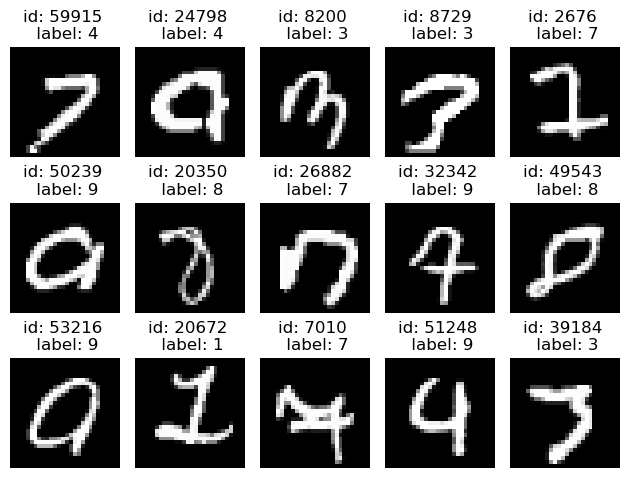

In [18]:
plot_examples(ranked_label_issues[range(15)], 3, 5)

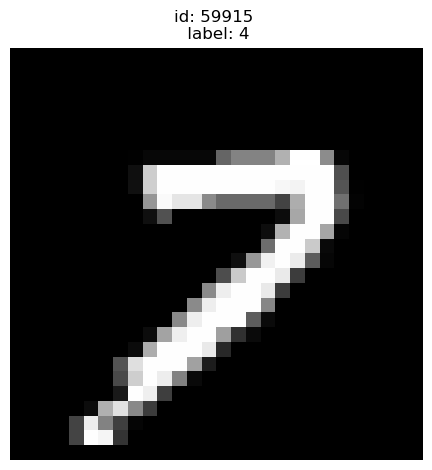

In [19]:
plot_examples([59915])

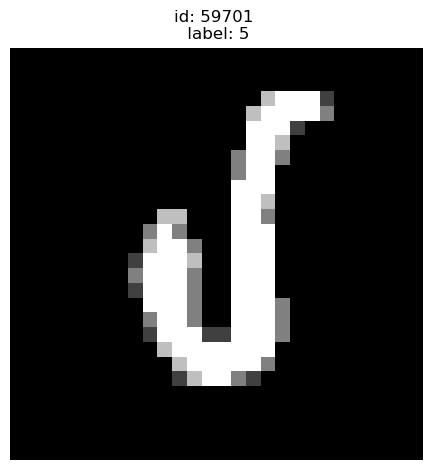

In [20]:
plot_examples([59701])